<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Effects of screen size and grid interval size on Component Localization Accuracy

The first step in Photocircuit's processing chain is identifying and classifying each component in the input circuit image. In a preprocessing step, the image is scaled, and an axis is added for reference to improve component localization. The preprocessed image is then analyzed by the Multi-modal LLM, which determines the location and classification of each component. An example is shown below.

This experiment tests how changes in screen size and interval size impact detection accuracy.

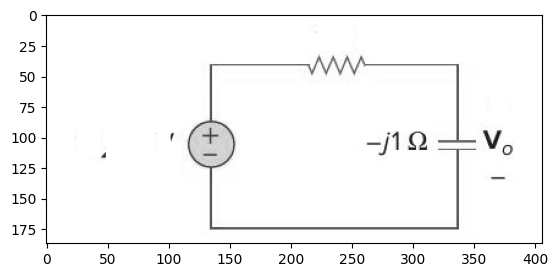

Example output for the image above




In [8]:
# components=[
#     Component(
#         position=ComponentPosition(x=2, y=5),
#         component_name=<ComponentName.VOLTAGE_SOURCE: 'voltage source'>
#     ),
#     Component(
#         position=ComponentPosition(x=5, y=5),
#         component_name=<ComponentName.RESISTOR: 'inductor'>
#     ),
#     Component(
#         position=ComponentPosition(x=8, y=5),
#         component_name=<ComponentName.CAPACITOR: 'capacitor'>
#     ),
# ]

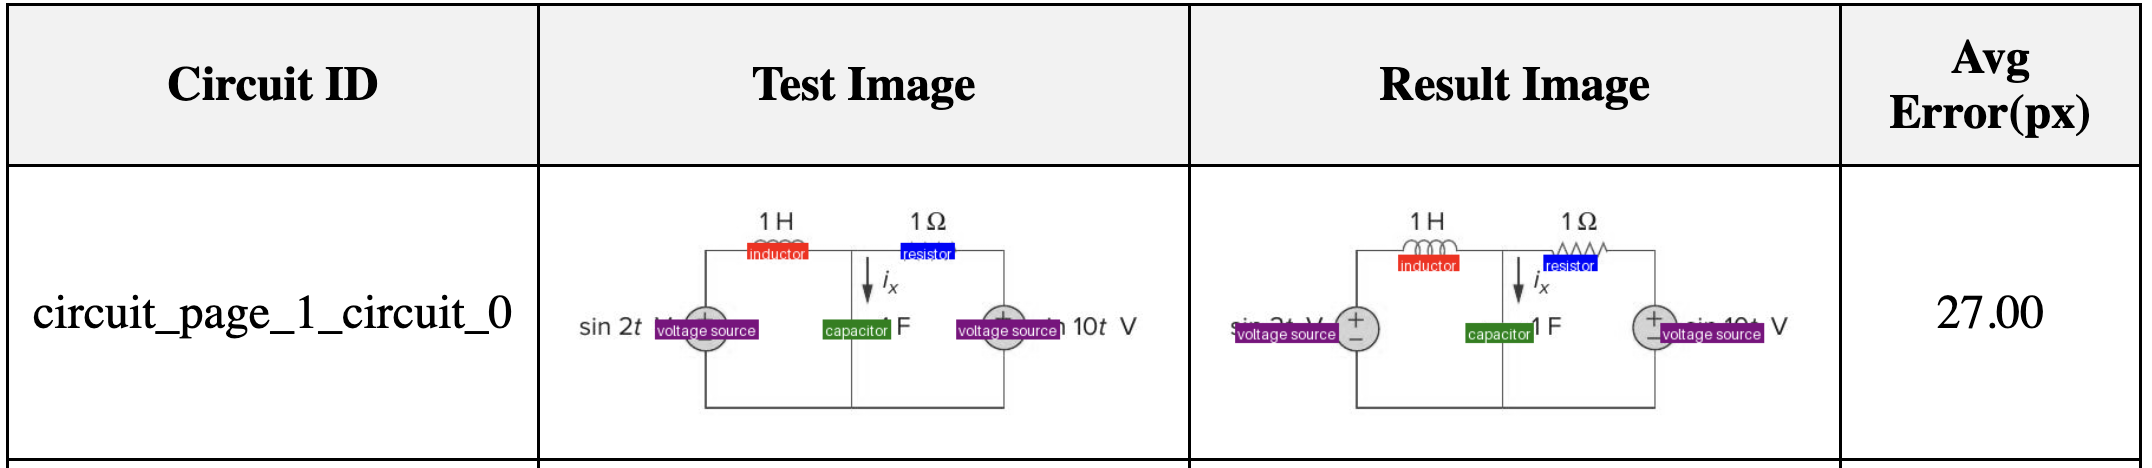

## Error Heuristic

$$Error[G \: | \: \Psi] = \frac{1}{S n} \sum_{k=0}^{n-1}{ \begin{cases} G_{k,name} \in \{ {C_{name} | C \in \Psi \} } : & min \{ \sqrt{||C_{pos} - G_{k,pos}||} \, \Big| \, C_{name} = G_{k,name}, C \in \Psi \} \\
\text{otherwise} : & \infty
\end{cases} }$$

$ $

$Error$ = error in component detection (% of image)

$S$ = max{width of image, height of image} (px)

$n$ = total predicted components(|G|)

$\Psi$ = Ground Truth components

$G_{k}$ = kth predicted component


As seen in the formula above, the error in a component prediction works out to a average of distances to ground truth component locations. This result is also scaled by $1/S$ to make the error independent of circuit image size and unitless.

Notice that if the llm predicts a component not in the image. For example, the llm predicting a current source in the first image above, the resulting error according to this heuristic would be $\infty$. These cases are handled seperately as "Infinite Error Counts".

### Common

In [ ]:
import pandas as pd

def show_average_error_grid(data):
  # Remove rows where Average Error is infinity for the first heatmap
  filtered_data = data[data['Average Error (px)'] != float('inf')]

  # Create a new column for Average Percent Error
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100

  # Calculate the mean Average Percent Error for each combination of Screen Size and Interval Size
  pivot_table_percent_error = filtered_data.pivot_table(values='Average Percent Error (%)', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='mean')

  # Calculate the total count of infinite Average Error for each combination of Screen Size and Interval Size
  data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)
  pivot_table_inf_count = data.pivot_table(values='inf_count', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='sum')

  import matplotlib.pyplot as plt
  import seaborn as sns

  # Plot the heatmaps side by side with linear color maps
  fig, axes = plt.subplots(1, 2, figsize=(20, 8))

  # Define a linear color map for percent error
  cmap_linear = 'RdYlGn_r'

  # First heatmap: Average Percent Error with linear color map
  sns.heatmap(pivot_table_percent_error, annot=True, cmap=cmap_linear, fmt=".2f", ax=axes[0])
  axes[0].set_title('Heatmap of Average Percent Error by Screen Size and Interval Size')

  # Define a linear color map for infinite errors
  cmap_linear_inf = 'RdYlGn_r'

  # Second heatmap: Count of Infinite Errors with linear color map
  sns.heatmap(pivot_table_inf_count, annot=True, cmap=cmap_linear_inf, fmt="d", ax=axes[1])
  axes[1].set_title('Heatmap of Count of Infinite Errors by Screen Size and Interval Size')

  plt.show()

# Read the data from the CSV file
file_path = '/content/drive/MyDrive/Photo_Circuit/data/data_analysis/screen_sizes_intv_spacing.csv'

# Read the data from the CSV file
all_data = pd.read_csv(file_path)

## Large Circuit

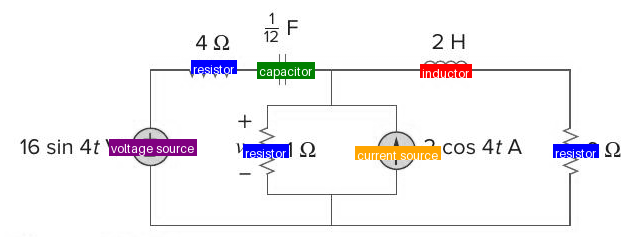

<ipython-input-1-5b62a8ced684>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100
<ipython-input-1-5b62a8ced684>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)


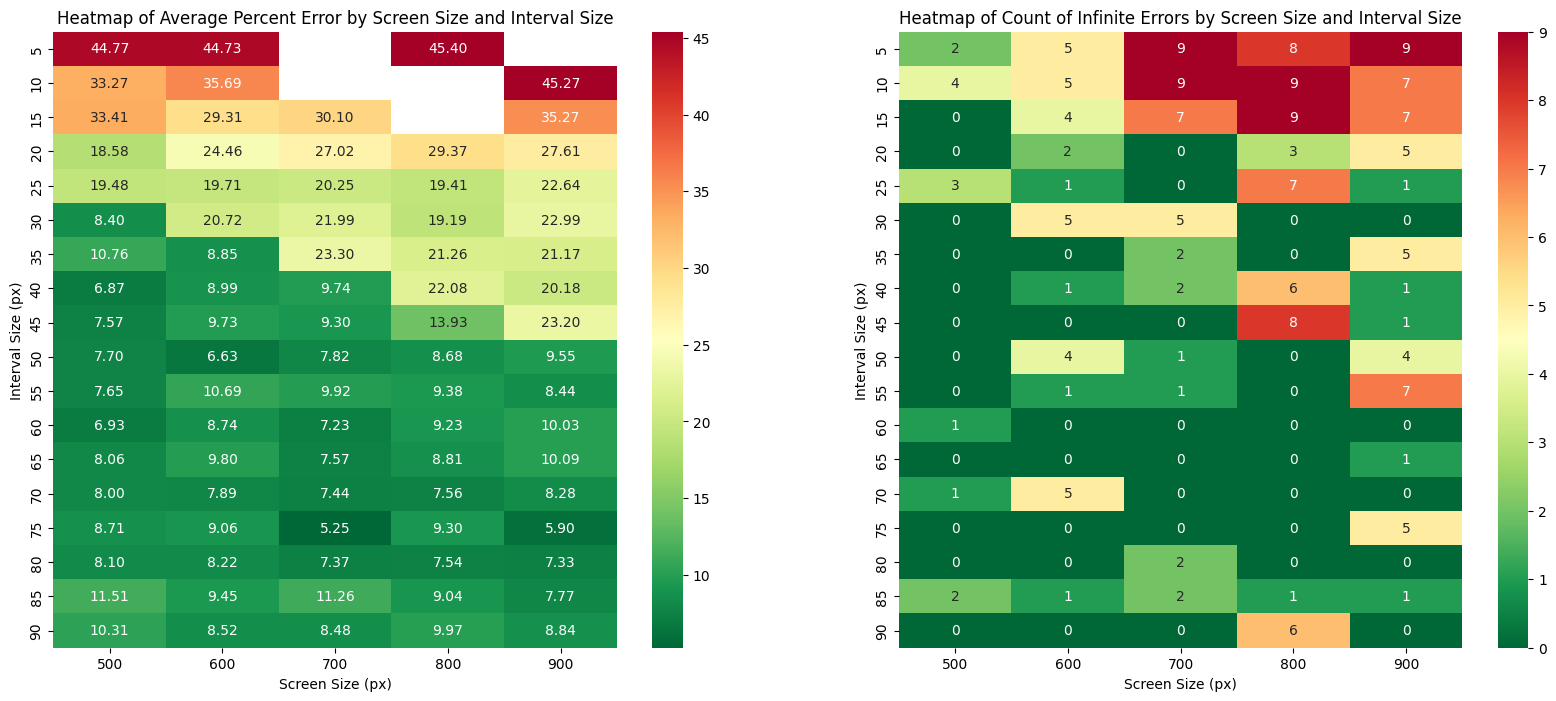

In [ ]:
large_circuit_id = 'circuit_page_2_circuit_4'

big_circuit_data = all_data[all_data['Circuit Id'] == large_circuit_id]

show_average_error_grid(big_circuit_data)

# Medium Circuit

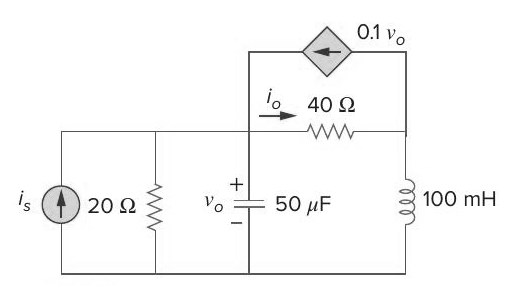

<ipython-input-1-5b62a8ced684>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100
<ipython-input-1-5b62a8ced684>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)


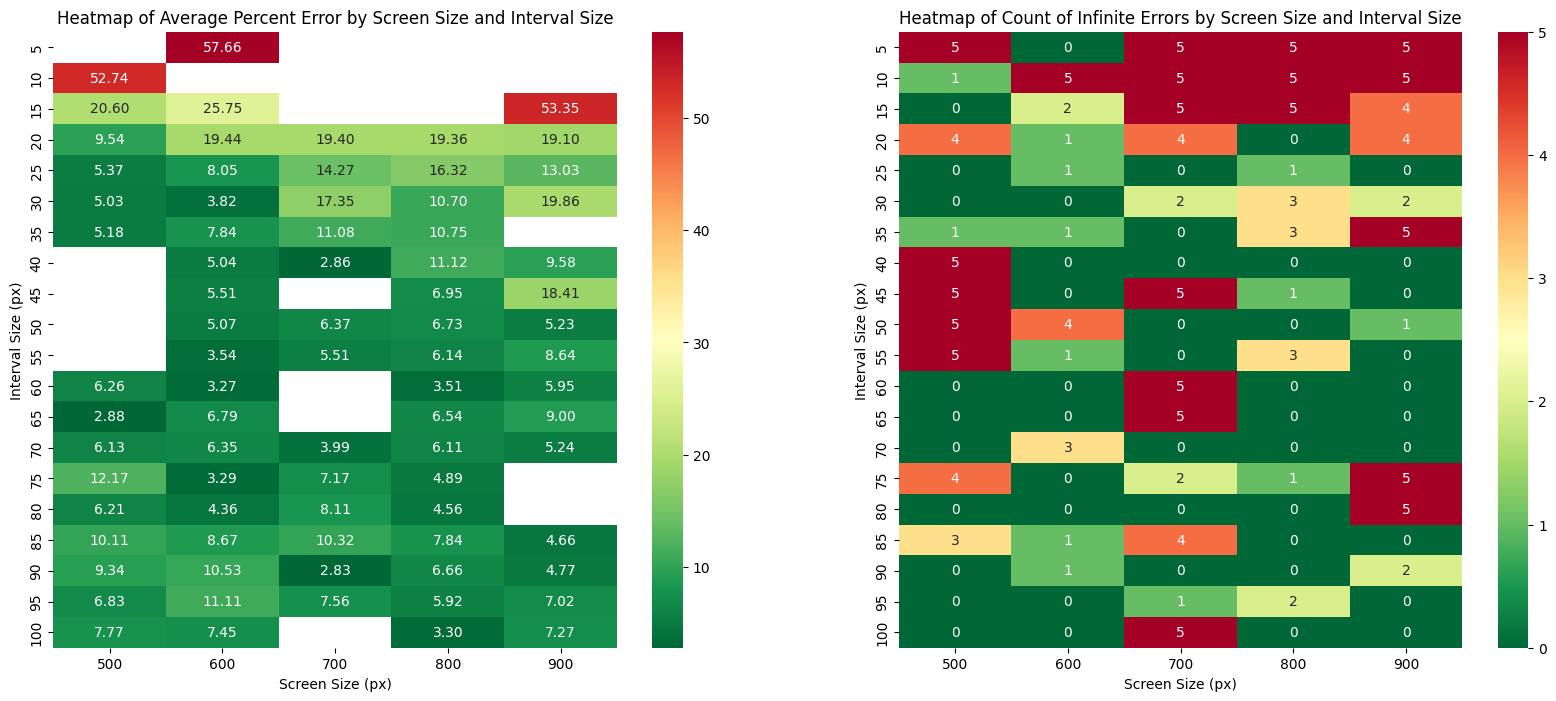

In [ ]:
medium_circuit_id = 'circuit_page_2_circuit_3'
medium_circuit_data = all_data[all_data['Circuit Id'] == medium_circuit_id]

show_average_error_grid(medium_circuit_data)

# Small Circuit

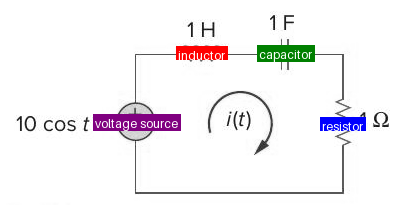

<ipython-input-1-5b62a8ced684>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)


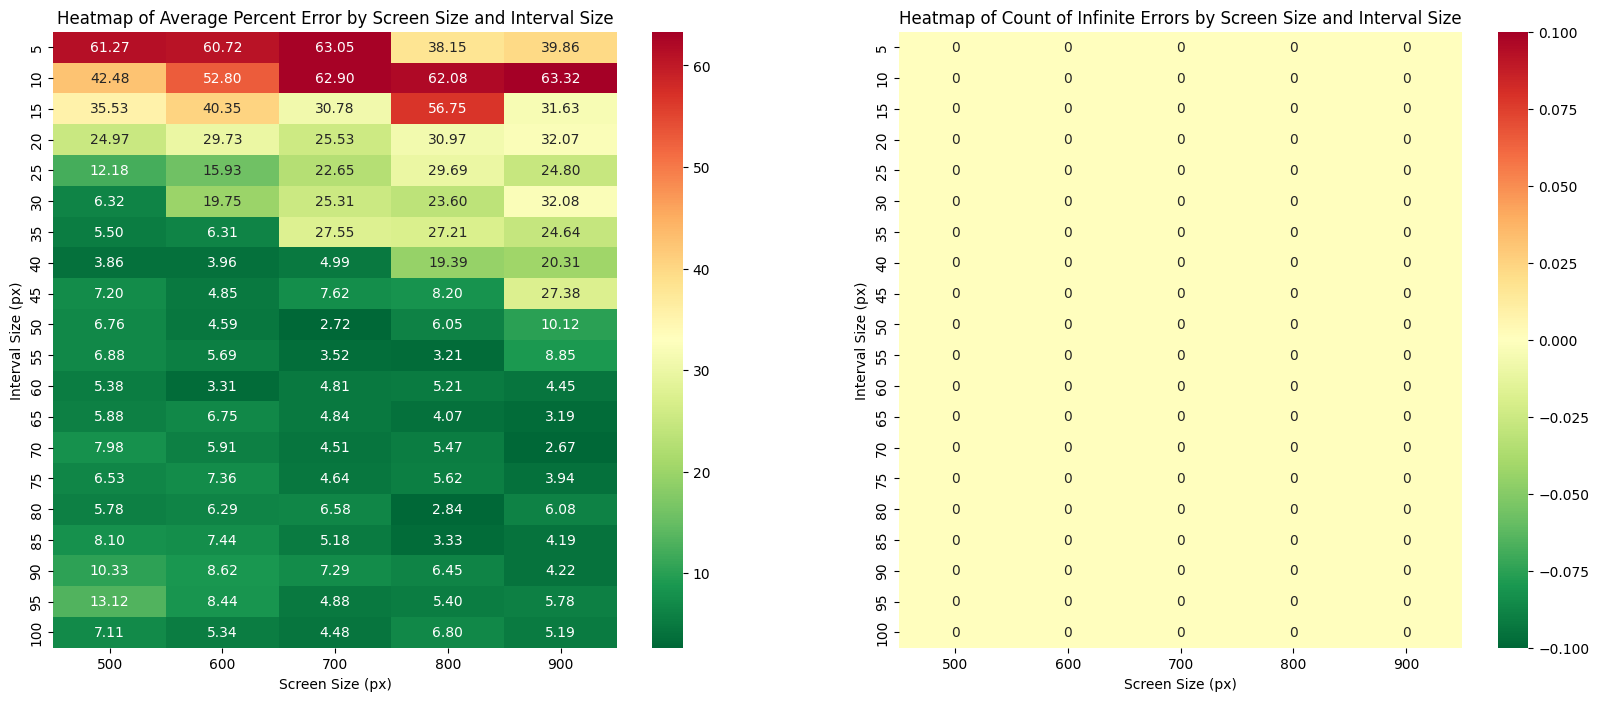

In [ ]:
small_circuit_id = 'circuit_page_1_circuit_2'

small_circuit_data = all_data[all_data['Circuit Id'] == small_circuit_id]

show_average_error_grid(small_circuit_data)

# Effects of model temperature

This section will be taking one circuit, and adjusting model temperature to see the effects of changing the llm temperature on component detection error. The metric used is listed above in the Error Heuristic section.

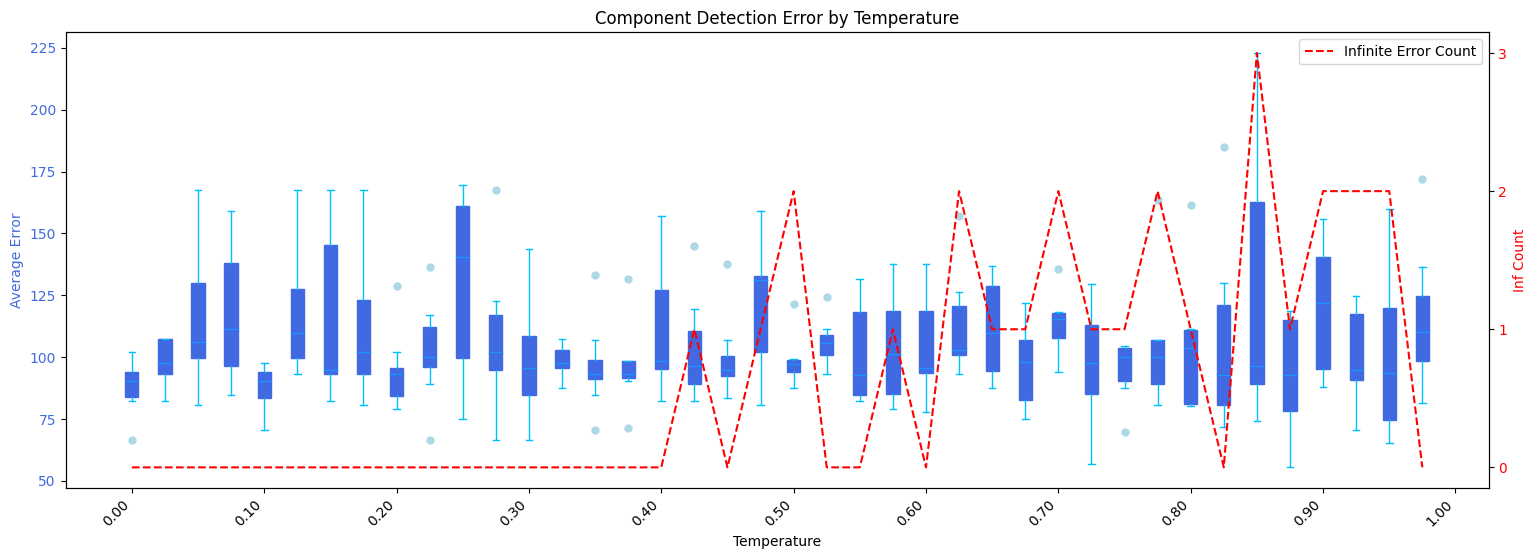

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the provided CSV file
file_path = '/content/drive/MyDrive/Photo_Circuit/data/data_analysis/temp_errors.csv'

# Reading the data from the CSV file
df = pd.read_csv(file_path)

# Filtering out rows where Average Error (px) is infinity
filtered_df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Average Error (px)"])

# Grouping the filtered data by Temperature and calculating the quartiles and min/max for each group
grouped_filtered_df = filtered_df.groupby('Temperature').agg(
    min_error=('Average Error (px)', 'min'),
    Q25_error=('Average Error (px)', lambda x: np.percentile(x, 25)),
    Q50_error=('Average Error (px)', lambda x: np.percentile(x, 50)),
    Q75_error=('Average Error (px)', lambda x: np.percentile(x, 75)),
    max_error=('Average Error (px)', 'max')
).reset_index()

# Identifying rows with infinity errors
inf_df = df[df["Average Error (px)"] == np.inf]

# Counting the number of rows with error = infinity for each temperature
inf_count_df = inf_df.groupby('Temperature').size().reset_index(name='inf_count')

# Merging the inf_count_df with grouped_filtered_df to ensure all temperatures are represented
merged_df = pd.merge(grouped_filtered_df, inf_count_df, on='Temperature', how='left')
merged_df['inf_count'].fillna(0, inplace=True)

# Creating the boxplot with a wider figure and rotated x-axis labels
fig, ax1 = plt.subplots(figsize=(16, 6))  # Increased figure size

# Boxplot: plotting the box for each temperature
ax1.boxplot(
    [filtered_df[filtered_df["Temperature"] == temp]["Average Error (px)"].values
     for temp in grouped_filtered_df["Temperature"]],
    positions=grouped_filtered_df["Temperature"],
    widths=0.01,
    patch_artist=True,
    boxprops=dict(facecolor='royalblue', color='royalblue'),
    whiskerprops=dict(color='deepskyblue'),
    capprops=dict(color='deepskyblue'),
    medianprops=dict(color='dodgerblue'),
    flierprops=dict(markerfacecolor='lightblue', markeredgecolor='lightblue', markersize=5),
    vert=True
)

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Average Error', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# 1. Reduce the number of ticks
ax1.set_xticks(np.round(np.arange(min(grouped_filtered_df["Temperature"]), max(grouped_filtered_df["Temperature"])+0.1, 0.1) / 0.05) * 0.05)

# 2. Rotate the labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# 3. Set tick format
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}'.format(val)))

ax1.set_xlim([min(grouped_filtered_df["Temperature"]) - 0.05, max(grouped_filtered_df["Temperature"]) + 0.05])  # Adjust x-axis limits

# Plotting the total number of inf rows as a line with red color
ax2 = ax1.twinx()
ax2.plot(merged_df["Temperature"], merged_df["inf_count"], color='red', linestyle='--', label='Infinite Error Count')
ax2.set_ylabel('Inf Count', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_yticks(np.arange(0, max(merged_df["inf_count"])+1, 1))

# Adding a legend
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

fig.tight_layout(pad=3.0)  # Add padding to prevent overlap
plt.title('Component Detection Error by Temperature')
plt.show()


# Conclusion

Based on the analysis above the following seems to be the best settings

$\begin{align}
\text{screen_size} &= 600\\
\text{interval_size} &= 60\\
\text{temperature} &= 0
\end{align}$

If the original image has size >600 pixels the following seems to work, but could benefit from more experimentation.

$\begin{align}
S &= \max(\text{width}, \text{height}) \\
\text{screen_size} &= 600 \: (S \: // \: 600 + 1)\\
\text{interval_size} &= 60 \: (S \: // \: 600 + 1)\\
\text{temperature} &= 0
\end{align}$